# 1. Overall sturcture of OCR
- OCR은 이미지 속에서 영문을 Bounding box로 찾아내고 그 Bounding box 내에 어떤 Text가 포함되는지 알 수 있는 시스템이다
- 이미지 속에서 문자 영역을 찾아내는 **Text Detection**은 이전에 봤던 방법 중 **Segmentation 기반의 CRAFT를 활용한 keras-ocr을 활용**한다
- **Recognition** 모델은 keras-ocr을 사용하지 않고 **직접 만들어본다**

# 2. Dataset for OCR
- Recognition model의 정량적인 평가를 위해서 MJSynth와 SynthText라는 데이터셋을 활용한다
-  Recognition model 학습을 위해 MJSynth를 사용한다

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


# 3. Recognition model
- Text recognition 모델을 직접 만들어보자
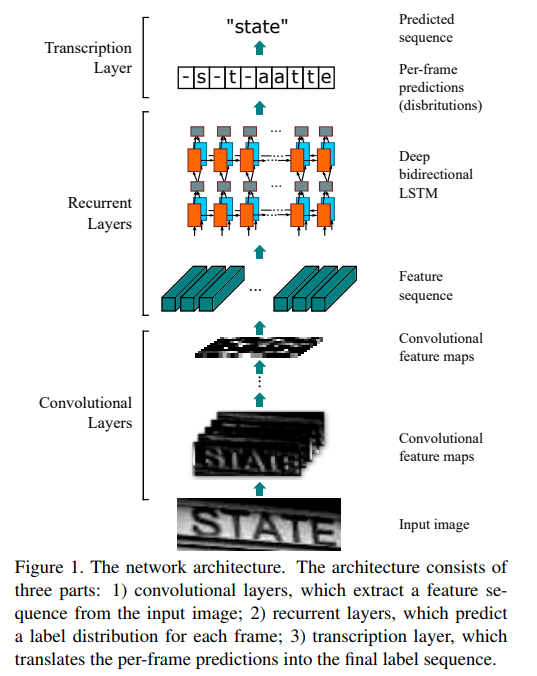

1. 입력이미지를 convolution layer를 통해 특징(feature)를 추출하여 추출된 특징(feature)을 얻어낸다
2. Recurrent layer는 추출된 특징(feature)의 전체적인 Context(앞뒤 정보의 흐름과 의미)를 파악하고 다양한 output의 크기에 대응이 가능한다
3. Transcription layer는 step마다 어떤 character의 확률이 높은지 예측한다

### 필요한 클래스 만들기

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


### lmdb
- 우리는 lmdb를 사용한다
- 다루게 될 데이터셋이 lmdb 포맷의 파일로 이루어져 있다  

### 라이브러리 불러오기

In [3]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


# 4. Recognition model: Input Image

### 데이터셋 안에 들어있는 이미지가 실제로 어떻게 생겼는지 확인해보자
- lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어서 실제 shape이 어떻게 생겼는지 이미지나 라벨은 어떻게 달려 있는지를 확인해보자

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


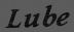

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


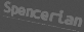

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


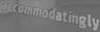

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


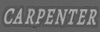

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

### lmdb를 활용하여 케라스 모델 학습용 MJSynth 데이터셋 클래스를 구현하려고 한다

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path, # 읽어들일 데이터셋의 경로
                 label_converter, # 문자를 미리 정의된 index로 변환
                 batch_size=1, # 한 번에 처리할 데이터의 배치 크기
                 img_size=(100,32), # 입력 이미지의 크기
                 max_text_len=22, # 라벨로 사용할 최대 텍스트 길이
                 is_train=False,
                 character='') :
        
        # 매개변수를 클래스 속성으로 저장
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100 # 데이터 분한 크기(배치 계산용)

        # lmdb 데이터베이스를 읽기 전용으로 연다
        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        
        # 데이터베이스에서 총 샘플 수를 읽고 1부터 시작하는 인덱스 리스트를 만든다
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode())) # 총 샘플 수
            self.index_list = [index + 1 for index in range(self.num_samples)] # 인덱스 리스트
        
    # sequence 인터페이스 구현: 전체 데이터셋에서 배치 개수를 반환한다
    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 특정 인덱스에 해당하는 이미지와 라벨을 읽어온다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            # 라벨을 가져오기 위한 키 생성
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8') # 라벨 읽기
            # 이미지를 가져오기 위한 키 생성
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key) # 이미지 데이터 읽기

            # 이미지 데이터를 메모리에서 읽어 PIL.Image 형식으로 변환한다
            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB') # RGB 이미지로 변환

            except IOError:
                # 오류 발생 시 기본 이미지 생성 및 라벨 대체
                img = Image.new('RGB', self.img_size)
                label = '-'
                
            # 이미지 크기를 비율에 맞게 조정
            width, height = img.size
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2) # 크기 변경 및 배열 변환
            
            # label을 약간 더 다듬습니다
            # 허용되지 않은 문자 제거 및 길이 제한
            label = label.upper() # 대문자로 변환
            out_of_char = f'[^{self.character}]' # 허용되지 않은 문자 패턴
            label = re.sub(out_of_char, '', label) # 정규식으로 제거
            label = label[:self.max_text_len] # 최대 길이로 자르기

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    
    # Sequence 인터페이스를 구현: 주어진 인덱스에 해당하는 배치를 반환한다
    def __getitem__(self, idx):
        # 1. 현재 배치에 해당하는 인덱스 리스트를 가져온다
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        
        # 입력 이미지와 라벨 배열을 초기화
        input_images = np.zeros([self.batch_size, *self.img_size, 3]) # (배치 크기, 이미지 크기, 채널)
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64') # 라벨 배열 초기화
        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len # 입력 길이
        label_length = np.ones([self.batch_size], dtype='int64') # 라벨 길이
        
        # 2. 각 인덱스에 대해 데이터를 읽어와서 처리합니다.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index) # 이미지와 라벨 읽기
            encoded_label = self.label_converter.encode(label) # 라벨을 인덱스로 인코딩
            
            # 인코딩된 라벨이 최대 길이를 초과하면 스킵
            if len(encoded_label) > self.max_text_len:
                continue
            # 이미지를 배열에 저장
            width = img.shape[0] # 이미지 너비
            input_images[i, :width, :, :] = img
            
            # 라벨을 배열에 저장
            labels[i, 0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label) # 실제 라벨 길이 저장
        
        # 3. 입력과 출력을 사전 형태로 준비
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        # CTC 손실 계산을 위해 더미 출력 생성
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs # 최종적으로 입력과 출력을 반환

print("완료")

완료


# Recognition model: Encode
- label이 우리가 읽을 수 있는 평문 Text로 이루어져 있다
- 이것은 모델을 학습하기 위해서 적절한 형태가 아니다
- 각 character를 class로 생각하고 이를 step에 따른 class index로 변환하여 encode를 해주어야 한다
- 이를 해줄 수 있는 **LabelConverter** 클래스를 작성해보자

In [6]:
# LabelConverter 클래스는 문자와 숫자(label)를 상호 변환하는 기능을 가지고 있다
class LabelConverter(object):

    # 클래스 초기화 메서드: 문자(character) 리스트를 기반으로 맵을 생성한다
    def __init__(self, character):
        self.character = "-" + character # 허용된 문자의 맨 앞에 '-'를 추가 (공백 문자 역할)

        # 문자를 숫자로 매핑하기 위한 딕셔너리를 생성
        self.label_map = dict()
        for i, char in enumerate(self.character): # 각 문자(character)를 숫자(index)로 매핑
            self.label_map[char] = i

    # 주어진 텍스트를 숫자(label)로 변환
    def encode(self, text):
        encoded_label = [] # 변환된 숫자를 저장할 리스트
        for i, char in enumerate(text):
            # 현재 문자와 이전 문자가 같으면 공백 문자(0)를 삽입
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0) # 같은 문자 사이에 공백 문자 label을 추가
            encoded_label.append(self.label_map[char]) # 현재 문자를 숫자로 변환하여 리스트에 추가
        return np.array(encoded_label) # 리스트를 NumPy 배열로 변환하여 반환

    # 숫자(label) 배열을 문자로 변환
    def decode(self, encoded_label):
        target_characters = list(self.character) # 허용된 문자를 리스트로 변환

        # 숫자를 문자로 변환하여 연결
        decoded_label = "" # 변환된 문자를 저장할 문자열
        for encode in encoded_label:
            decoded_label += self.character[encode] # 숫자(label)를 문자(character)로 변환하여 추가

        return decoded_label

In [7]:
# TARGET_CHARACTERS는 허용된 문자 집합입니다.
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO') # 'HELLO'라는 텍스트를 숫자(label) 배열로 변환합니다.
print("Encoded_text: ", encdoded_text) # 변환된 숫자 배열을 출력합니다.
decoded_text = label_converter.decode(encdoded_text) # 숫자 배열을 다시 텍스트로 복원합니다.
print("Decoded_text: ", decoded_text) # 복원된 텍스트를 출력합니다.

Encoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


# 6. Recognition model: Build CRNN model
- 모델 만들기
- keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func 만들기

In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args # labels: 정답 라벨, y_pred: 모델이 예측한 출력, label_length: 각 라벨의 실제 길이, input_length: 각 입력 시퀀스의 길이
    y_pred = y_pred[:, 2:, :] # 모델 출력 y_pred의 초기 두 타임스텝 제거 (CTC 손실 계산을 위한 사전처리)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("완료")

완료


### K.ctc_batch_cost()를 활용하여 image_input을 입력으로 마지막 label을 "output"이라는 이름으로 출력하는 레이어를 갖도록 모델을 만드는 함수 build_crnn_model()을 구현하자

In [9]:
# CRNN 모델을 만드는 함수
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2 # 총 문자 수(36) + 시작,종료 구분용 추가 문자(2) = 38
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # CNN 부분
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    
    # RNN 부분
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    # ctc loss를 위한 추가 입력
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    
    # ctc 손실 계산 레이어
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    
    # 모델 정의
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("완료")

완료


# Recognition model: Train & Inference
- 앞에서 정의한 MJDatasetSequence로 데이터를 적절히 분리하여 구성된 데이터셋을 통해 학습해보자

In [10]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [33]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 100, 32, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 32, 64)  1792        input_image[0][0]                
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 50, 16, 64)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 50, 16, 128)  73856       max_pooling2d_4[0][0]            
____________________________________________________________________________________________

### 모델 학습하기

In [11]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

ckp = ModelCheckpoint(filepath=checkpoint_path, 
                      save_weights_only=True, 
                      save_best_only=False,
                      verbose=1)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp]
)

Epoch 1/20
565/565 [==============================] - 107s 157ms/step - loss: 25.2384 - val_loss: 23.9193

Epoch 00001: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 2/20
565/565 [==============================] - 82s 144ms/step - loss: 13.0665 - val_loss: 8.9024

Epoch 00002: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 3/20
565/565 [==============================] - 81s 144ms/step - loss: 6.6659 - val_loss: 6.2214

Epoch 00003: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 4/20
565/565 [==============================] - 81s 143ms/step - loss: 4.8962 - val_loss: 5.3562

Epoch 00004: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 5/20
565/565 [==============================] - 81s 144ms/step - loss: 3.9093 - val_loss: 4.6052

Epoch 00005: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 6/20
565/565 [==============================] - 81s 144ms/step - loss: 3.1985 - val_loss: 4.3784

Epoch 00006: saving mo

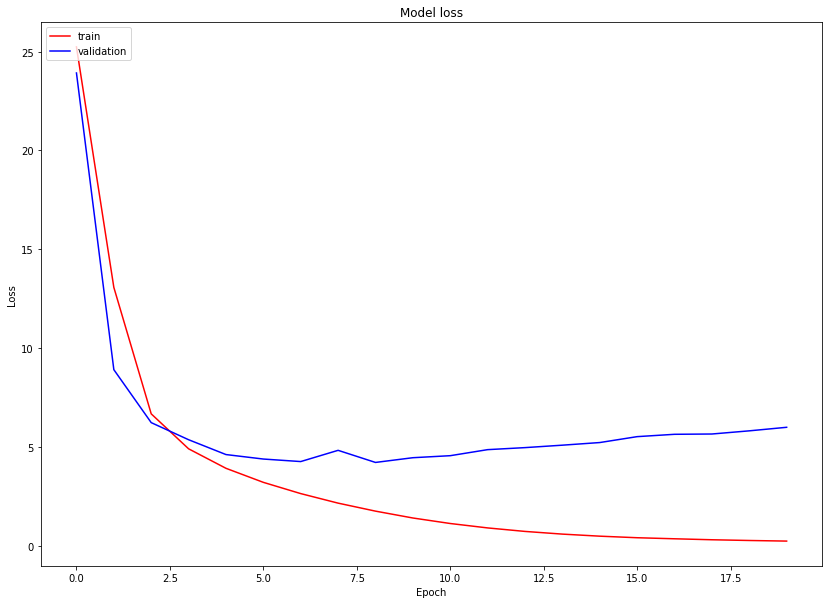

In [12]:
plt.figure(figsize=(14, 10))

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'b')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

### 랜덤한 이미지 결과 확인하기

In [28]:
import random

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 랜덤 데이터를 뽑아 모델 inference를 수행합니다
def check_inference_random(model, dataset, num_samples=10):
    dataset_size = len(dataset)  # 데이터셋 크기 가져오기
    random_indices = random.sample(range(dataset_size), num_samples)  # 랜덤한 인덱스 선택

    for i in random_indices:
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1, :, :, :]  # 이미지 데이터 가져오기
        output = model.predict(img)  # 모델 예측 수행
        result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')  # 결과 디코딩
        print(f"Index: {i}, Result: \t{result}")  # 결과 출력
        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))  # 이미지를 출력

Index: 50, Result: 	ROULETTE999999999999999


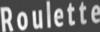

Index: 7, Result: 	ROBOTIC99999999999999999


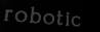

Index: 47, Result: 	TAMPA9999999999999999999


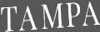

Index: 61, Result: 	LOUNGING9999999999999999


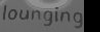

Index: 36, Result: 	SEPESERS999999999999999


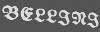

Index: 21, Result: 	DODOIED99999999999999999


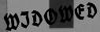

Index: 23, Result: 	POLYGLETS999999999999999


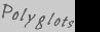

Index: 32, Result: 	BLUEPRINT999999999999999


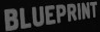

Index: 37, Result: 	DLICES999999999999999999


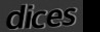

Index: 55, Result: 	HEDONIST9999999999999999


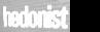

In [30]:
check_inference_random(model_pred, test_set, num_samples=10)

---
---
---

## 데이터셋 링크

- https://gagori.github.io/OCR_Dataset/
- https://davelogs.tistory.com/77
- https://rrc.cvc.uab.es/?com=contestant&view=after_new&email=dpihan1816@gmail.com
- https://www.kaggle.com/datasets/bestofbests9/icdar2015/code

---
---
---

In [ ]:
# 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)
     
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [46]:
def predict_and_get_outputs(model, img_path):
    # (conv, pool) 레이어만 출력. flatten 레이어 이전까지.
    layer_outputs = [layer.output for layer in model.layers[:8]]
    layer_names = [layer.name for layer in model.layers[:8]]
    
    # 각 레이어의 출력 형태를 출력
    print("Layer output shapes before prediction:")
    for output in layer_outputs:
        print(output.shape)
    
    # 다중 입력 모델 처리
    if isinstance(model.input, list):
        input_shape = (model.input[0].shape[1], model.input[0].shape[2])  # 다중 입력의 첫 번째 텐서 선택
    else:
        input_shape = (model.input.shape[1], model.input.shape[2])  # 단일 입력의 경우

    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    img_tensor = load_image(img_path, target_size=input_shape)
    
    print("Shapes before prediction:")
    for layer in layer_outputs:
        print(layer.shape)
    print('-' * 50)

    layer_outputs = activation_model.predict(img_tensor)
    print("Shapes after prediction:")
    for layer in layer_outputs:
        print(layer.shape)

    return layer_outputs, layer_names

# 레이어 출력 및 이름 확인
layer_outputs, layer_names = predict_and_get_outputs(model, label)

Layer output shapes before prediction:
(None, 100, 32, 3)
(None, 100, 32, 64)
(None, 50, 16, 64)
(None, 50, 16, 128)
(None, 25, 8, 128)
(None, 25, 8, 256)
(None, 25, 8, 256)
(None, 25, 4, 256)


NameError: name 'load_image' is not defined

In [40]:
# 원하는 인덱스의 이미지를 선택
selected_index = 3

# LMDB에서 선택한 이미지를 불러오기
with env.begin(write=False) as txn:
    # 라벨과 이미지 키 생성
    label_key = 'label-%09d'.encode() % selected_index
    img_key = 'image-%09d'.encode() % selected_index
    
    # 라벨과 이미지 데이터 가져오기
    label = txn.get(label_key).decode('utf-8')
    imgbuf = txn.get(img_key)
    
    # 이미지 데이터를 변환
    buf = six.BytesIO()
    buf.write(imgbuf)
    buf.seek(0)
    try:
        img = Image.open(buf).convert('RGB')  # RGB로 변환
    except IOError:
        img = Image.new('RGB', (100, 32))  # 오류 발생 시 빈 이미지 생성
        label = '-'

    # 모델 입력 형태로 변환 (차원 추가)
    input_image = np.expand_dims(np.array(img), axis=0)

    # 선택된 이미지 출력
    print(f"Selected Index: {selected_index}, Label: {label}")
    display(img)

# 시각화하고 싶은 레이어 이름
layer_name = 'conv2d_7'  # 예: Conv2D 레이어 이름

# 피처맵 시각화
visualize_feature_map(model_pred, layer_name, input_image)

Selected Index: 3, Label: accommodatingly


ValueError: No such layer: conv2d_7.